# Brain Stroke Detector

In [1]:
import os
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

The datasets are read from a set of images downloaded from Kaggle at this [link](https://www.kaggle.com/datasets/afridirahman/brain-stroke-ct-image-dataset). It contains CT images of normal brains and brains affected by stroke.

In [2]:
def get_image_datasets(images_path, validation_split=0.2, target_size=(224,224), batch_size=20):
  """Generates the training and validation image datasets"""
  img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255, 
      validation_split=validation_split)

  train_ds = img_generator.flow_from_directory(
      images_path,
      target_size=target_size,
      batch_size=batch_size,
      shuffle=True,
      class_mode='binary',
      subset='training'
  )

  validation_ds = img_generator.flow_from_directory(
      images_path,
      target_size=target_size,
      batch_size=batch_size,
      shuffle=True,
      class_mode='binary',
      subset='validation'
  )

  return train_ds, validation_ds

A Convolutional Neural Network (CNN) is used to perform Image Classification on the Brain Stroke dataset. Since the dataset is small, the training of the entire neural network would not provide good results so the concept of Transfer Learning is used to train the model to get more accurate results. Transfer Learning represents a method wherein a model developed for a particular task is used as a starting point for another task. In particular, the `InceptionV3` model with `imagenet` weights will be used for the current task.

In [3]:
def create_model(input_shape=(224, 224, 3), inner_size=100, drop_rate=0.1, learning_rate=0.001):
  """Creates the CNN model based on Transfer Learning"""
  base_model = tf.keras.applications.InceptionV3(input_shape=input_shape,
                                                include_top=False,
                                                weights="imagenet")

  base_model.trainable = False

  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(inner_size, activation='relu'),
      tf.keras.layers.Dropout(rate=drop_rate),
      tf.keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [4]:
def train_model(model, model_path, train_ds, validation_ds, steps_per_epoch=20, epochs=20, callbacks=[]):
  """Trains the model"""
  history = model.fit(train_ds, 
                      validation_data=validation_ds, 
                      steps_per_epoch=steps_per_epoch, 
                      epochs=epochs,
                      callbacks=callbacks)
  
  return history, model

In [5]:
ROOT_PATH = 'drive/MyDrive/ColabNotebooks'
IMAGES_PATH = ROOT_PATH + os.sep + 'brain_ct_data'

In [6]:
train_ds, validation_ds = get_image_datasets(images_path=IMAGES_PATH)

Found 2001 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Hereafter, the summary of the CNN model based on the default parameters.

In [7]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 22,007,785
Trainable params: 205,001
Non-trainable params: 21,802,784
______________________________________

Multiple learning rates are first tested.

In [8]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
  print(lr)

  model = create_model(learning_rate=lr)
  history, model = train_model(model, model_path=ROOT_PATH, train_ds=train_ds, validation_ds=validation_ds)

  scores[lr] = history.history

0.0001
Epoch 1/20
20/20 [==============================] - 72s 3s/step - loss: 0.7156 - accuracy: 0.5925 - val_loss: 0.6693 - val_accuracy: 0.6220
Epoch 2/20
20/20 [==============================] - 64s 3s/step - loss: 0.6928 - accuracy: 0.5700 - val_loss: 0.6561 - val_accuracy: 0.6380
Epoch 3/20
20/20 [==============================] - 64s 3s/step - loss: 0.6047 - accuracy: 0.7000 - val_loss: 0.6529 - val_accuracy: 0.6440
Epoch 4/20
20/20 [==============================] - 65s 3s/step - loss: 0.6476 - accuracy: 0.6425 - val_loss: 0.6458 - val_accuracy: 0.6140
Epoch 5/20
20/20 [==============================] - 63s 3s/step - loss: 0.6187 - accuracy: 0.6483 - val_loss: 0.6360 - val_accuracy: 0.6440
Epoch 6/20
20/20 [==============================] - 64s 3s/step - loss: 0.5805 - accuracy: 0.6950 - val_loss: 0.6552 - val_accuracy: 0.6640
Epoch 7/20
20/20 [==============================] - 65s 3s/step - loss: 0.5927 - accuracy: 0.7025 - val_loss: 0.6291 - val_accuracy: 0.6700
Epoch 8/20
20

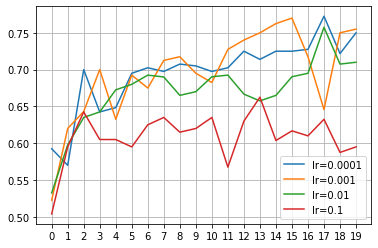

In [9]:
for lr, history in scores.items():
  plt.plot(history['accuracy'], label=('lr=%s' % lr))

plt.xticks(np.arange(20))
plt.legend()
plt.grid()

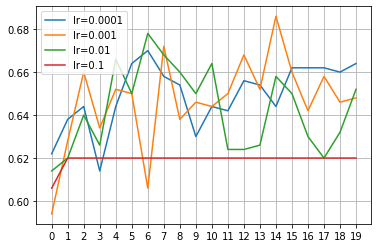

In [10]:
for lr, history in scores.items():
  plt.plot(history['val_accuracy'], label=('lr=%s' % lr))

plt.xticks(np.arange(20))
plt.legend()
plt.grid()

Then, the best learning rate value is selected and multiple sizes for the inner dense layer are checked.

In [11]:
BEST_LEARNING_RATE=0.001

In [12]:
scores = {} 

for size in [10, 100, 1000]:
  print(size)

  model = create_model(learning_rate=BEST_LEARNING_RATE, inner_size=size)
  history, model = train_model(model, model_path=ROOT_PATH, train_ds=train_ds, validation_ds=validation_ds)

  scores[size] = history.history

10
Epoch 1/20
20/20 [==============================] - 69s 3s/step - loss: 0.7228 - accuracy: 0.6025 - val_loss: 0.6400 - val_accuracy: 0.6340
Epoch 2/20
20/20 [==============================] - 64s 3s/step - loss: 0.6776 - accuracy: 0.6075 - val_loss: 0.6671 - val_accuracy: 0.6120
Epoch 3/20
20/20 [==============================] - 64s 3s/step - loss: 0.6661 - accuracy: 0.6200 - val_loss: 0.6463 - val_accuracy: 0.6360
Epoch 4/20
20/20 [==============================] - 66s 3s/step - loss: 0.6735 - accuracy: 0.6100 - val_loss: 0.6697 - val_accuracy: 0.6040
Epoch 5/20
20/20 [==============================] - 63s 3s/step - loss: 0.6412 - accuracy: 0.6450 - val_loss: 0.6627 - val_accuracy: 0.6200
Epoch 6/20
20/20 [==============================] - 62s 3s/step - loss: 0.6607 - accuracy: 0.5984 - val_loss: 0.6615 - val_accuracy: 0.6200
Epoch 7/20
20/20 [==============================] - 64s 3s/step - loss: 0.6136 - accuracy: 0.6475 - val_loss: 0.6402 - val_accuracy: 0.6200
Epoch 8/20
20/20 

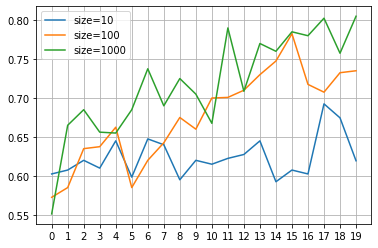

In [13]:
for size, history in scores.items():
  plt.plot(history['accuracy'], label=('size=%s' % size))

plt.xticks(np.arange(20))
plt.legend()
plt.grid()

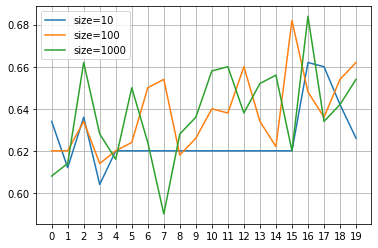

In [14]:
for size, history in scores.items():
  plt.plot(history['val_accuracy'], label=('size=%s' % size))

plt.xticks(np.arange(20))
plt.legend()
plt.grid()

Finally, multiple dropout rate are verified to find the best value.

In [15]:
BEST_SIZE=1000

In [16]:
scores = {}

for drop_rate in [0.0, 0.2, 0.5, 0.8]:
  print(drop_rate)

  model = create_model(learning_rate=BEST_LEARNING_RATE, inner_size=BEST_SIZE, drop_rate=drop_rate)
  history, model = train_model(model, model_path=ROOT_PATH, train_ds=train_ds, validation_ds=validation_ds)

  scores[drop_rate] = history.history

0.0
Epoch 1/20
20/20 [==============================] - 74s 4s/step - loss: 1.6395 - accuracy: 0.5750 - val_loss: 0.6542 - val_accuracy: 0.6600
Epoch 2/20
20/20 [==============================] - 71s 4s/step - loss: 0.6799 - accuracy: 0.5875 - val_loss: 0.7287 - val_accuracy: 0.6240
Epoch 3/20
20/20 [==============================] - 69s 4s/step - loss: 0.6968 - accuracy: 0.5900 - val_loss: 0.6594 - val_accuracy: 0.5760
Epoch 4/20
20/20 [==============================] - 68s 3s/step - loss: 0.6172 - accuracy: 0.6575 - val_loss: 0.6215 - val_accuracy: 0.6860
Epoch 5/20
20/20 [==============================] - 72s 4s/step - loss: 0.5967 - accuracy: 0.6875 - val_loss: 0.6400 - val_accuracy: 0.6320
Epoch 6/20
20/20 [==============================] - 64s 3s/step - loss: 0.6773 - accuracy: 0.6115 - val_loss: 0.6307 - val_accuracy: 0.6520
Epoch 7/20
20/20 [==============================] - 64s 3s/step - loss: 0.5845 - accuracy: 0.6925 - val_loss: 0.6412 - val_accuracy: 0.6340
Epoch 8/20
20/20

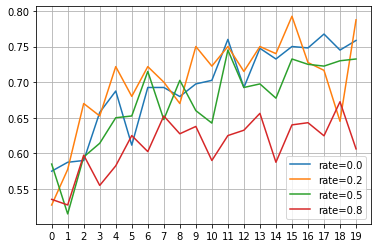

In [17]:
for rate, history in scores.items():
  plt.plot(history['accuracy'], label=('rate=%s' % rate))

plt.xticks(np.arange(20))
plt.legend()
plt.grid()

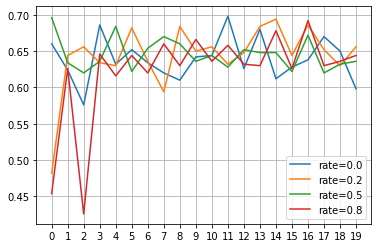

In [18]:
for rate, history in scores.items():
  plt.plot(history['val_accuracy'], label=('rate=%s' % rate))

plt.xticks(np.arange(20))
plt.legend()
plt.grid()

In [ ]:
BEST_DROP_RATE=0.2